# Street Pathing Efficiency EPS109 Final Project by Laksmana Hamrozalli

Document Styling

In [62]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')

Modules Imported

In [63]:
import numpy as np
import networkx as nx
import osmnx as ox
import pickle
import pyvista as pv
from pyvista import examples
from matplotlib import *
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
metadata = dict(title='STREET',artist='laks',comment='pathing')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point
from IPython.display import Image
import geopandas as gpd
import pandas as pd
from IPython.display import IFrame
import ipywidgets as widgets
import folium
import random
from pathlib import Path

Address Widget

In [66]:
addressInput = widgets.Textarea(
 value='San Francisco, California',
 placeholder='Street, City, State',
 description='Address:'
 )
display(addressInput)

Textarea(value='San Francisco, California', description='Address:', placeholder='Street, City, State')

# Type desired address for analysis in text box widget above. Afterwards, run the cells below.

Setting the Address Variable

In [67]:
#Note to user: Make sure desired address is in the text box input above prior to running this cell.
print(f'Address: {addressInput.value}')
address = addressInput.value

Address: 2601 Warring Street Berkeley, California


Creating the OSMNX Graph, Nodes, and Edges

C:\Users\lhamr\AppData\Local\Temp\ipykernel_17412\3424198123.py:6: ResourceWarning: unclosed file <_io.BufferedWriter name='osmnx_graph.p'>
  pickle.dump(graph, open('osmnx_graph.p', 'wb'))


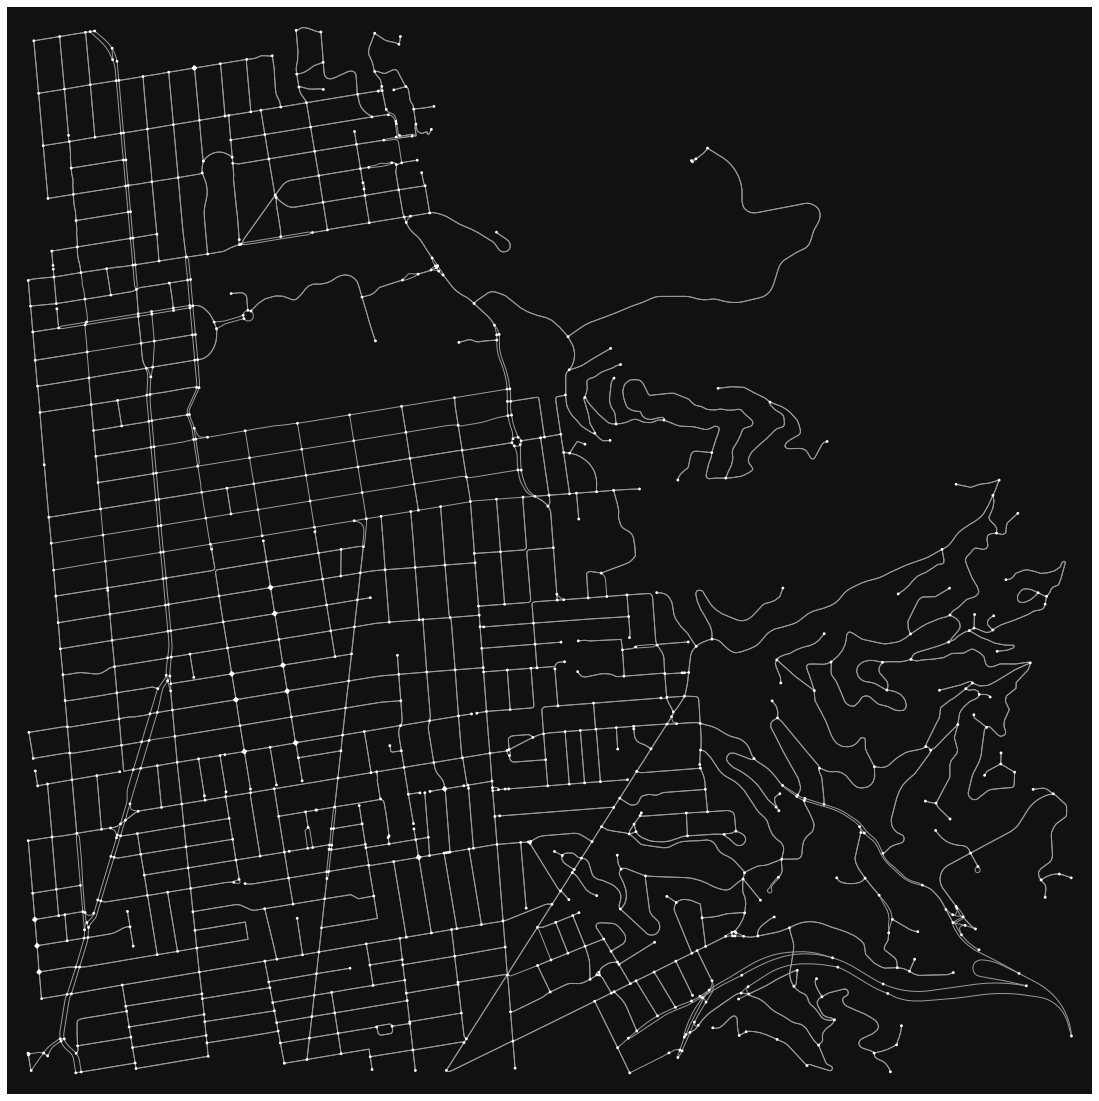

In [68]:
graph = ox.graph_from_address(address, network_type='drive',dist=2000)
nodes= ox.graph_to_gdfs(graph, nodes=True, edges=False)
edges= ox.graph_to_gdfs(graph, edges=True, nodes=False)
for i in range(len(list(graph.nodes))):
    node_id = list(graph.nodes)[i]
pickle.dump(graph, open('osmnx_graph.p', 'wb'))  
ox.plot_graph(graph,node_size=8, edge_linewidth=1, edge_alpha=1, figsize=(20,20), dpi=800)
ox.plot_graph_folium(graph,popup_attribute='name', edge_width=2)

Creating Building Nodes for Reference

In [69]:
buildings = ox.geometries_from_address(address, tags={'building':True},dist=2000)
centroids = buildings.centroid

lons = list(centroids.x)
lats = list(centroids.y)

building_coords = [[lons[i],lats[i]] for i in range(len(lons))]

C:\Users\lhamr\AppData\Local\Temp\ipykernel_17412\2509123438.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid


Creating Dataframes for the Building Nodes and Graphing Them

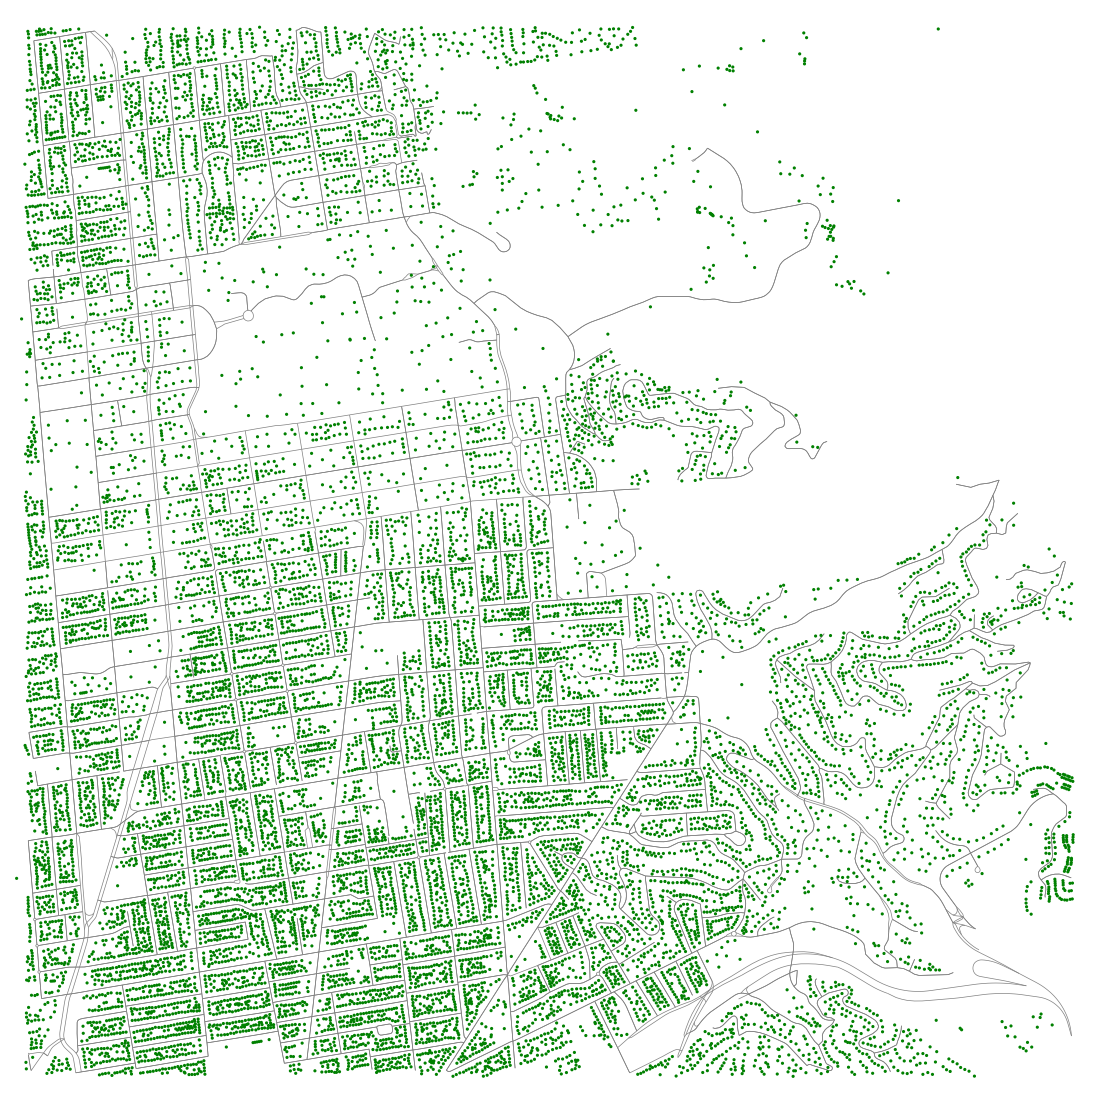

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot: >)

In [70]:
dictionary = dict()

for i in range(len(building_coords)):
     node_id = i+1
     dictionary[node_id] = {
    'x': lons[i],
    'y': lats[i]
     }

tmp_list = []
for item_key, item_value in dictionary.items() :
  tmp_list.append({
    'geometry' : Point(item_value['x'], item_value['y']),
    'osmid': item_key,
    'y' : item_value['y'],
      'x' : item_value['x'],
   })
my_nodes = gpd.GeoDataFrame(tmp_list)

Buildnodes = my_nodes

graph2 = ox.graph_from_gdfs(Buildnodes, edges)
ox.plot_graph(graph2, node_size=10, edge_color="grey", node_color="green", edge_linewidth=0.7, bgcolor="white", figsize=(20,20), dpi=800)

Converting Dataframes of Streets and Street Nodes to PyVista PolyData Plots

In [71]:
streets = []
for _, row in edges.iterrows():
    x_pts = row['geometry'].xy[0]
    y_pts = row['geometry'].xy[1]
    z_pts = np.zeros(len(x_pts))
    pts = np.column_stack((x_pts, y_pts, z_pts))
    street = pv.lines_from_points(pts)
    streets.append(street)
    
streetnodes = []
for _, row in nodes.iterrows():
    x_pts2 = row['geometry'].xy[0]
    y_pts2 = row['geometry'].xy[1]
    z_pts2 = np.zeros(len(x_pts2))
    pts2 = np.column_stack((x_pts2, y_pts2, z_pts2))
    streetnode = pv.PolyData(pts2)
    streetnodes.append(streetnode)
    
combined_streets = streets[0].merge(streets[1:])
combined_streetnodes = streetnodes[0].merge(streetnodes[1:])
combined_streets_and_streetnodes = combined_streets.merge(combined_streetnodes)

Using Point Picking and Mesh Picking to Allow Users to Select Desired Street Nodes for Street Pathing

In [72]:
p = pv.Plotter()
line_actor = p.add_mesh(combined_streets, pickable=False)
building_actor = p.add_mesh(combined_streetnodes, pickable=True)
p.enable_point_picking(show_message="Press P to pick street node location 1 under the mouse",point_size=20,use_mesh=True,color='Blue')
p.pickable_actors = [building_actor]
p.view_xy()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Make sure desired point for building 1 is picked above and cell is ran once again prior to running this cell.

Sets the First Street Node Location

In [73]:
#Note to user: Make sure desired point for building 1 is picked above prior to running this cell.
origin = (p.picked_point[0],p.picked_point[1])
print(f'Street Node 1 Location: {origin}')

Street Node 1 Location: (-122.2580568, 37.8712562)


Creates the Pickable Actor for the Second Street Node Selection Interface

In [74]:
p.enable_point_picking(show_message="Press P to pick street node location 2 under the mouse",point_size=20,use_mesh=True,color='Green')
p.pickable_actors = [building_actor]
p.view_xy()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Make sure desired point for building 2 is picked above and cell is ran once again prior to running this cell.

Sets the Second Street Node Location

In [75]:
#Note to user: Make sure desired point for building 2 is picked above prior to running this cell.
destination = (p.picked_point[0],p.picked_point[1])
print(f'Street Note 2 Location: {destination}')

Street Note 2 Location: (-122.2380167, 37.8478572)


Shortest Path Between The Two Street Nodes

Street Node 1 Location: (-122.2580568, 37.8712562)
Street Node 2 Location: (-122.2380167, 37.8478572)
Street Node 1 OSMID: 52991832
Street Note 2 OSMID: 53021639


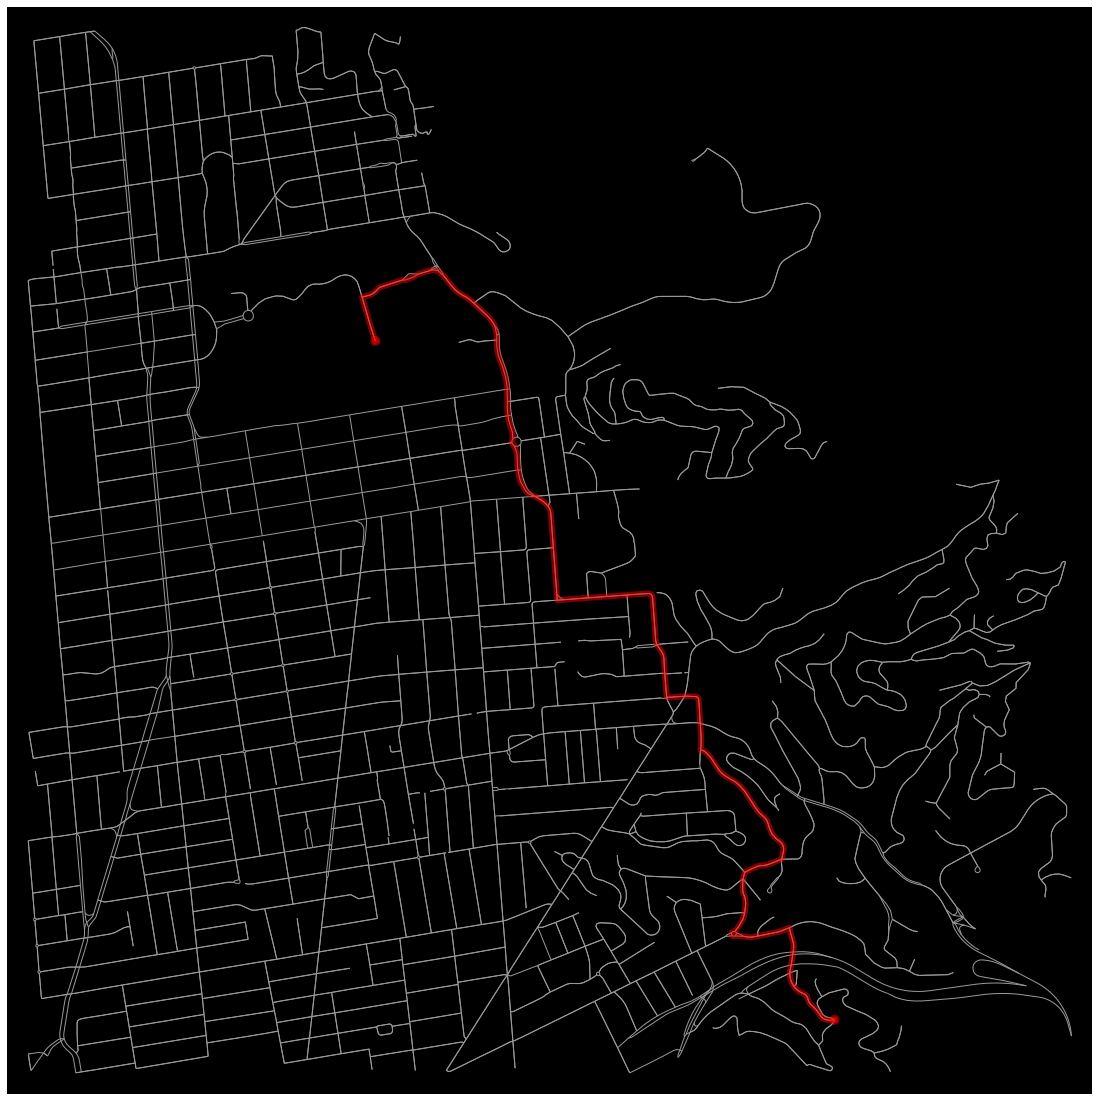

In [76]:
print(f'Street Node 1 Location: {origin}')
print(f'Street Node 2 Location: {destination}')
for rowIndex, row in nodes.iterrows():
    if((origin[0] == row['x']) and (origin[1] == row['y'])):
        IDorigin = rowIndex
        print(f'Street Node 1 OSMID: {IDorigin}')
        break
for rowIndex, row in nodes.iterrows():
    if((destination[0] == row['x']) and (destination[1] == row['y'])):
        IDdestination = rowIndex
        print(f'Street Note 2 OSMID: {IDdestination}')
        break
        
route = nx.shortest_path(graph, IDorigin, IDdestination, weight='length')
fig, ax = ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20,20), dpi=800)
ox.plot_route_folium(graph,route,route_width=3,route_color='#AA1111',titles=address,popup_attribute='name')

Shortest Path Between The Two Street Nodes Via One-Way Streets

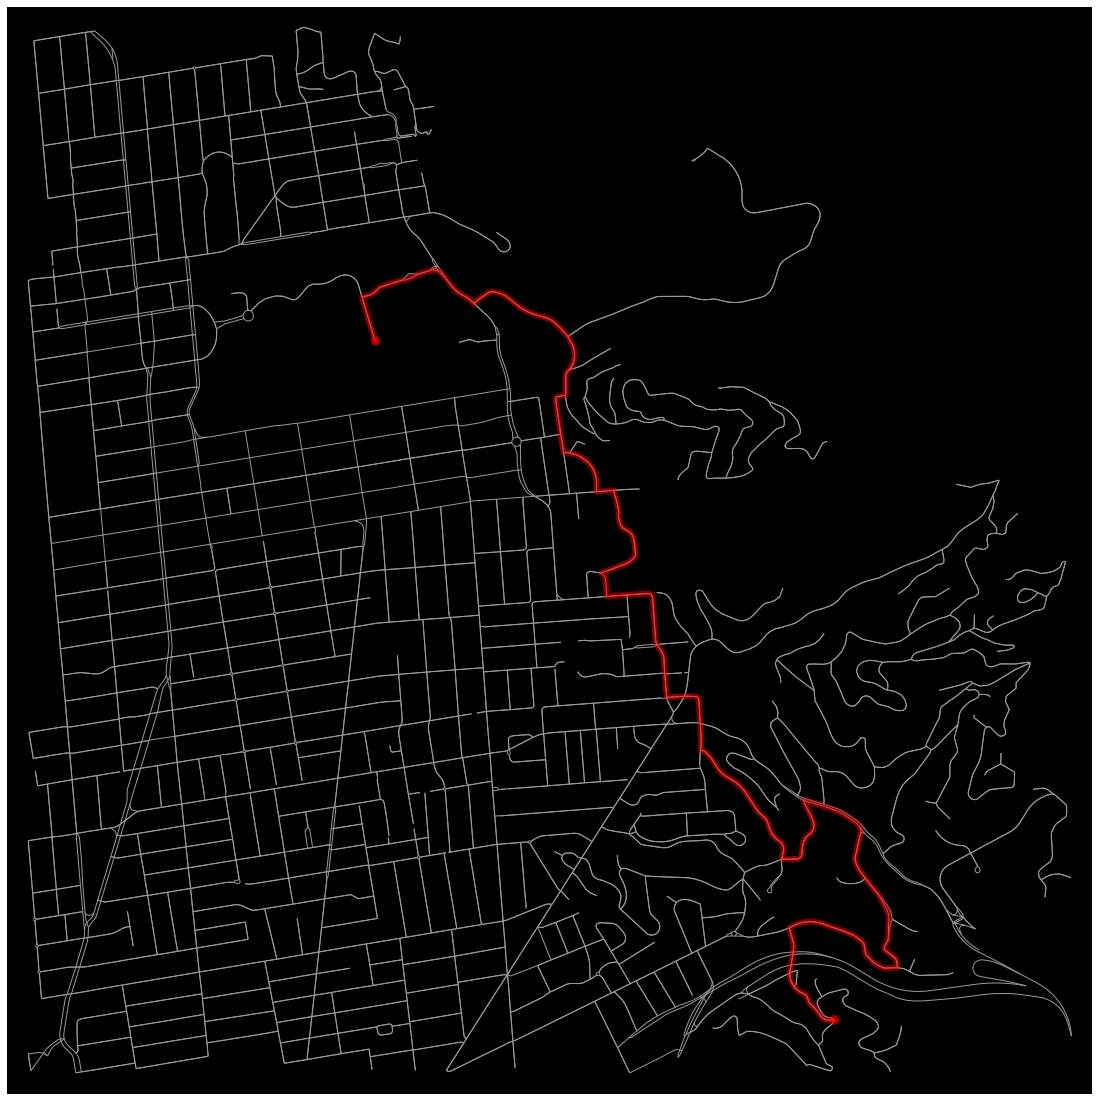

In [77]:
origin_node = ox.nearest_nodes(graph, origin[0], origin[1])
destination_node = ox.nearest_nodes(graph, destination[0], destination[1])
route = nx.shortest_path(graph, origin_node, destination_node)
fig, ax = ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20,20), dpi=800)
ox.plot_route_folium(graph,route,route_width=3,route_color='#AA1111',titles=address,popup_attribute='name')

Speed and Time Values Taken Into Account

In [78]:
#Adds speed values from OSM. default_speeds serves to fill in any missing highway speeds in the data.
default_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
graph = ox.add_edge_speeds(graph, default_speeds)

#Calculates travel times for each of the edges in the plot
graph = ox.add_edge_travel_times(graph)

#Calculates mean speed/time values by road type based on the location's OSM data
edges = ox.graph_to_gdfs(graph, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

length  speed_kph  travel_time
highway                                                        
['unclassified', 'residential']   443.3       32.0         49.9
motorway                          270.8       92.5         10.2
motorway_link                     329.4       93.9         12.1
primary                            92.3       41.9          7.9
primary_link                       45.3       55.0          3.0
residential                       125.1       39.0         11.7
secondary                         103.0       41.1          9.0
secondary_link                     69.5       55.0          4.5
tertiary                          110.8       43.8          9.5
tertiary_link                      26.7       40.2          2.4
unclassified                      108.6       25.7         15.2

Routes with Distance v.s. Travel Time

In [79]:
#Calculates the shortest path between the two street nodes based on distance.
route1 = nx.shortest_path(graph, IDorigin, IDdestination, weight='length')
#Calculates the path between the two street nodes that has the predicted shortest travel time.
route2 = nx.shortest_path(graph, IDorigin, IDdestination, weight='travel_time')

Comparison of Distance v.s. Travel Time in Routes Between User's Desired Street Nodes

In [80]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route2, 'travel_time')))
print('Route 1 (red) is', route1_length, 'meters and takes', route1_time, 'seconds. This is the shortest distance.')
print('Route 2 (green) is', route2_length, 'meters and takes', route2_time, 'seconds. This is the shortest travel time.')

Route 1 (red) is 4644 meters and takes 417 seconds. This is the shortest distance.
Route 2 (green) is 4644 meters and takes 417 seconds. This is the shortest travel time.


Graph of the Two Routes (Distance v.s. Travel Time)

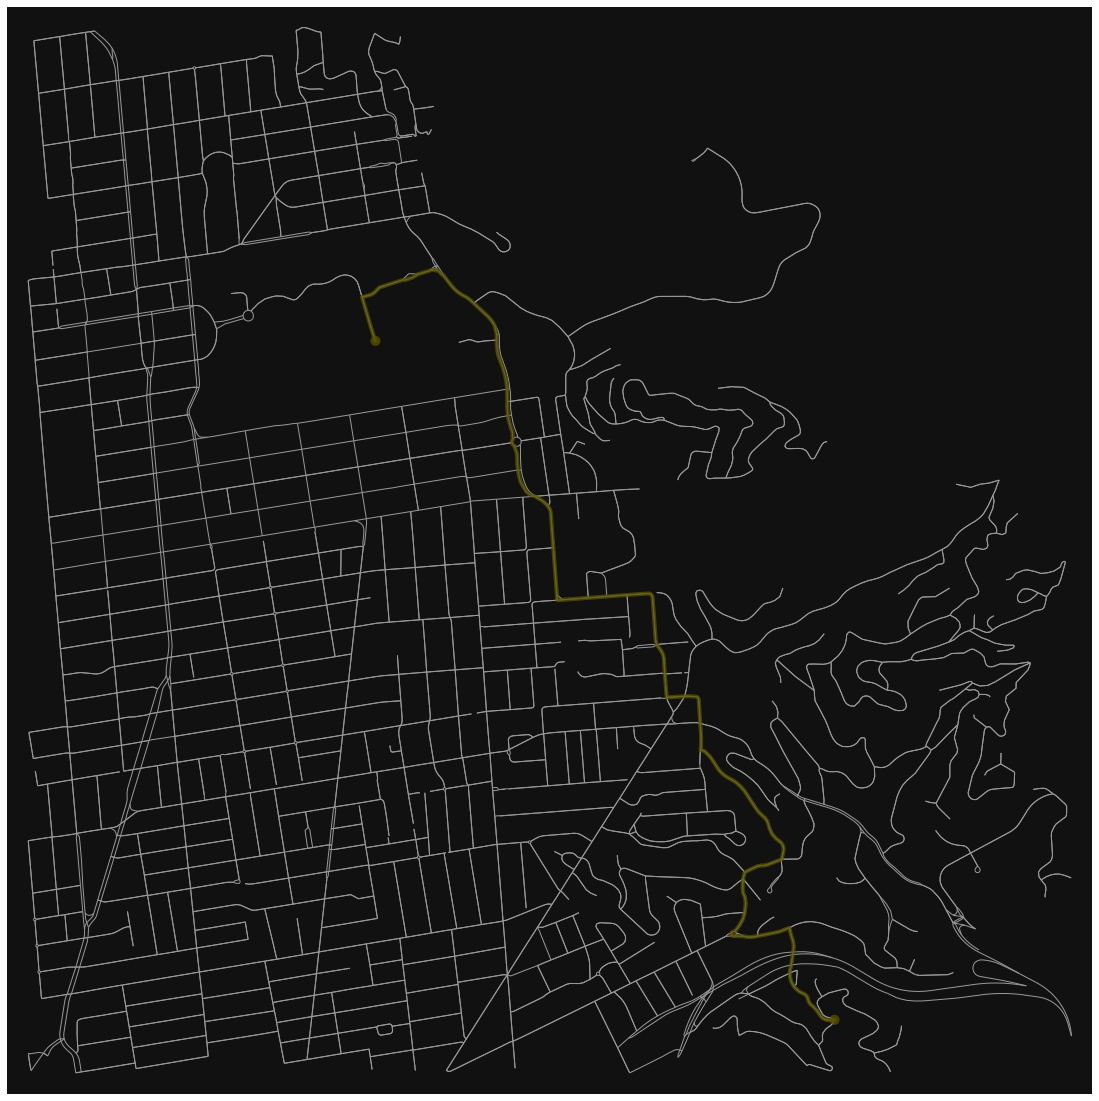

In [81]:
routes = [route1, route2]
rc = ['r','g']
fig, ax = ox.plot_graph_routes(graph, routes, route_colors=rc, route_linewidth=6, node_size=0, figsize=(20,20), dpi=800)

Random Walk Function (Uses First Node Location as Start Location)

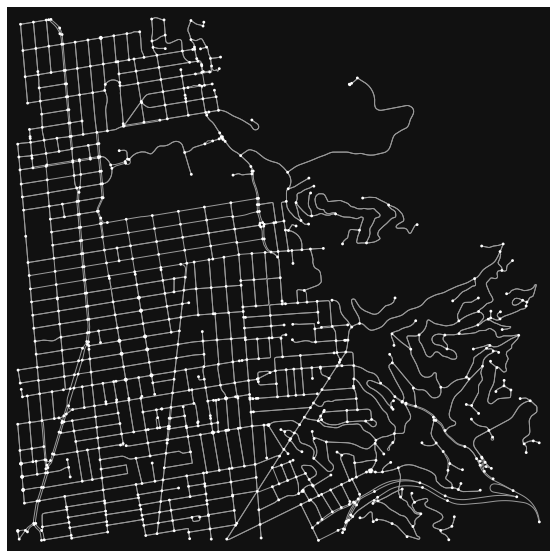

<Figure size 432x288 with 0 Axes>

In [82]:
fig3, ax = ox.plot_graph(graph,node_size=8, edge_linewidth=1, edge_alpha=1, node_zorder=2,figsize=(10,10))
fig = plt.figure() 
def randomWalk(G,ax,oldSpot,delay,steps):
    streets = []
    touched = {start:1}
    plt.figure(figsize=(10,10))
    for step in range(steps):
        neighbors = [z for z in G.neighbors(oldSpot)]
        newSpot = random.choice(neighbors)
        plt.plot([G.nodes[oldSpot]['x'],G.nodes[newSpot]['x']],
                [G.nodes[oldSpot]['y'],G.nodes[newSpot]['y']],color='blue')
        #fig.savefig(os.path.join(ffmpeg_path,'_'.join([str(seed),str(i).rjust(int(np.log10(n))+1,'0')+'.png'])))
        #writer.grab_frame()
        streets.append([[G.nodes[oldSpot]['x'],G.nodes[newSpot]['x']],[G.nodes[oldSpot]['y'],G.nodes[newSpot]['y']]])
        oldSpot = newSpot
        if oldSpot in touched:
            touched[oldSpot] += 1
        else:
            touched[oldSpot] = 1
            
    return pd.Series(touched), streets

Creates a Random Walk Around First Node's Location

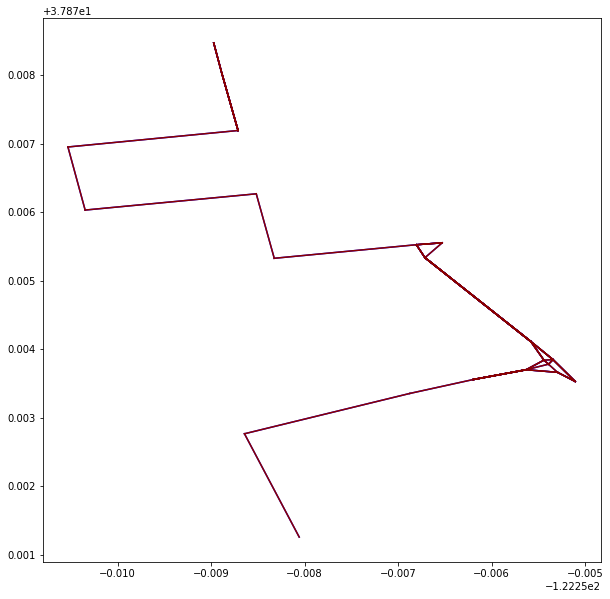

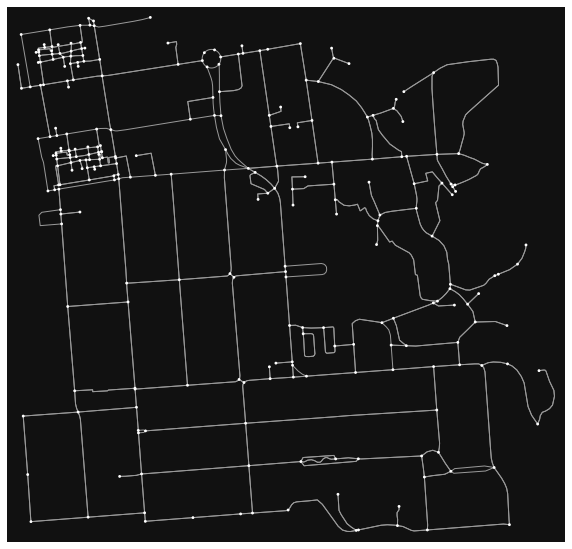

(<Figure size 720x720 with 1 Axes>, <AxesSubplot: >)

In [83]:
#plt.rcParams['animation.ffmpeg_path']=r'C:\Users\lhamr\OneDrive\Desktop\ffmpeg.exe'
n = 70
#frame = 10
seed = random.randint(0,9)
random.seed(seed)
#ffmpeg_path = os.path.join(r'C:\Users\lhamr\OneDrive\Desktop',str(seed))
#Path(ffmpeg_path).mkdir(parents=True, exist_ok=True)

#with writer.saving(fig, "randomWalk.mp4", dpi=200):
start = IDorigin

freqs,edges = randomWalk(graph,ax,IDorigin,1,n)

_ = ax.scatter(x=origin[0],y=origin[1],s=100,marker='x',color='black',zorder=3)

i = 0
for edge in edges:
#         if (i % frame) == 0:
#             fig.savefig(os.path.join(ffmpeg_path,'_'.join([str(seed),str(i).rjust(int(np.log10(n))+1,'0')+'.png'])))
#             writer.grab_frame()
    plt.plot(edge[0],edge[1], color='darkred')
    i += 1

    #fig.savefig(os.path.join(ffmpeg_path,'_'.join([str(seed),str(i),'.png'])))

figZoom = ox.graph_from_address(address, dist=500)
ox.plot_graph(figZoom,node_size=8, edge_linewidth=1, edge_alpha=1, figsize=(10,10))